HW 6. Experiment with multiclass classification (MLP) for MNIST data set

Include dropout layers

Include batch normalization layers

Include more layers

Experiment with activation functions

Experiment presence / absence of dropout and batch normalization

Experiment with batch size

Plot loss = f(epochs) for each experiment

First, let's add the losses plot to the original MNIST MLP model to have this model as a benchmark.

Using device: cpu
# Params: 159010
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.321859
Train Epoch: 0 [1000/60000 (2%)]	Loss: 1.826732
Train Epoch: 0 [2000/60000 (3%)]	Loss: 1.124478
Train Epoch: 0 [3000/60000 (5%)]	Loss: 0.933236
Train Epoch: 0 [4000/60000 (7%)]	Loss: 0.606949
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.387457
Train Epoch: 0 [6000/60000 (10%)]	Loss: 0.289856
Train Epoch: 0 [7000/60000 (12%)]	Loss: 0.537321
Train Epoch: 0 [8000/60000 (13%)]	Loss: 0.393156
Train Epoch: 0 [9000/60000 (15%)]	Loss: 0.832469
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.181064
Train Epoch: 0 [11000/60000 (18%)]	Loss: 0.052365
Train Epoch: 0 [12000/60000 (20%)]	Loss: 0.088084
Train Epoch: 0 [13000/60000 (22%)]	Loss: 0.446085
Train Epoch: 0 [14000/60000 (23%)]	Loss: 0.702687
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.076155
Train Epoch: 0 [16000/60000 (27%)]	Loss: 0.289117
Train Epoch: 0 [17000/60000 (28%)]	Loss: 0.196137
Train Epoch: 0 [18000/60000 (30%)]	Loss: 0.942845
Train Epoch: 0 [19000/60000 (32%)]

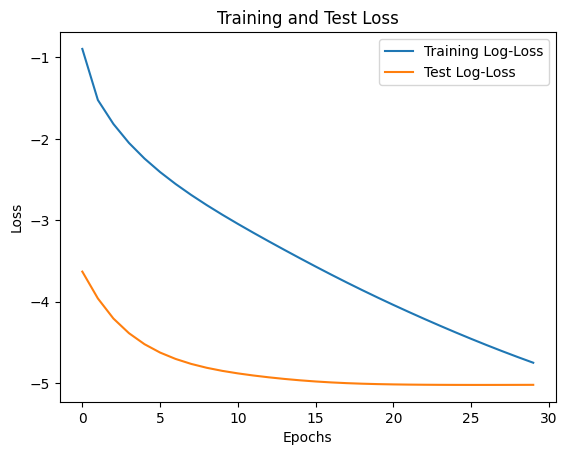

In [4]:
"""
Dataset references:
http://pjreddie.com/media/files/mnist_train.csv
http://pjreddie.com/media/files/mnist_test.csv
"""

from pathlib import Path
from typing import Tuple
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1337)

class MnistMlp(torch.nn.Module):
    
    def __init__(self, inputnodes: int, hiddennodes: int, outputnodes: int) -> None:
        super().__init__()

        # number of nodes (neurons) in input, hidden, and output layer
        self.wih = torch.nn.Linear(in_features=inputnodes, out_features=hiddennodes)
        self.who = torch.nn.Linear(in_features=hiddennodes, out_features=outputnodes)
        self.activation = torch.nn.Sigmoid()

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.wih(x)
        out = self.activation(out)
        out = self.who(out)
        return out


class MnistDataset(Dataset):
    
    def __init__(self, filepath: Path) -> None:
        super().__init__()

        self.data_list = None
        with open(filepath, "r") as f:
            self.data_list = f.readlines()

        # conver string data to torch Tensor data type
        self.features = []
        self.targets = []
        for record in self.data_list:
            all_values = record.split(",")
            features = np.asfarray(all_values[1:])
            target = int(all_values[0])
            self.features.append(features)
            self.targets.append(target)

        self.features = torch.tensor(np.array(self.features), dtype=torch.float) / 255.0
        self.targets = torch.tensor(np.array(self.targets), dtype=torch.long)
        # print(self.features.shape)
        # print(self.targets.shape)
        # print(self.features.max(), self.features.min())

    
    def __len__(self) -> int:
        return len(self.features)
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.features[index], self.targets[index]


if __name__ == "__main__":
    # Device for training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize empty lists to store training and test losses during training
    training_losses = []
    test_losses = []

    # NN architecture:
    # number of input, hidden and output nodes
    input_nodes = 784
    hidden_nodes = 200
    output_nodes = 10

    # learning rate is 0.1
    learning_rate = 0.1
    # batch size
    batch_size = 10
    # number of epochs
    epochs = 30

    # Load mnist training and testing data CSV file into a datasets
    train_dataset = MnistDataset(filepath="./mnist_train.csv")
    test_dataset = MnistDataset(filepath="./mnist_test.csv")

    # Make data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    # Define NN
    model = MnistMlp(inputnodes=input_nodes, 
                     hiddennodes=hidden_nodes, 
                     outputnodes=output_nodes)
    # Number of parameters in the model
    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    model = model.to(device=device)
    
    # Define Loss
    criterion = torch.nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    ##### Training! #####
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        test_loss = 0.0
        correct = 0

        for batch_idx, (features, target) in enumerate(train_loader):
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(features), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            
            # Accumulate the running loss
            running_loss += loss.item()
    
        # Calculate the average training loss for the epoch
        average_train_loss = running_loss / len(train_loader)
        training_losses.append(average_train_loss)
        ##### Testing! #####
        model.eval()
        with torch.inference_mode():
            for features, target in test_loader:
                features, target = features.to(device), target.to(device)
                output = model(features)
                test_loss += criterion(output, target).item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    ##### Plotting Loss! #####
    plt.plot(range(len(training_losses)), np.log(training_losses), label='Training Log-Loss')
    plt.plot(range(len(test_losses)), np.log(test_losses), label='Test Log-Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

    ##### Save Model! #####
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    torch.save(model.state_dict(), "mnist_01.pth")



We get pretty accurate benchmark model: Average testing loss: 0.0066, Accuracy: 0.9797. The testing log-loss seems to be minimum after 15 epochs. Let's add a dropout.

Using device: cpu
# Params: 159010
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.308360
Train Epoch: 0 [1000/60000 (2%)]	Loss: 1.853880
Train Epoch: 0 [2000/60000 (3%)]	Loss: 1.142387
Train Epoch: 0 [3000/60000 (5%)]	Loss: 0.894435
Train Epoch: 0 [4000/60000 (7%)]	Loss: 0.666147
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.393036
Train Epoch: 0 [6000/60000 (10%)]	Loss: 0.332049
Train Epoch: 0 [7000/60000 (12%)]	Loss: 0.610342
Train Epoch: 0 [8000/60000 (13%)]	Loss: 0.475771
Train Epoch: 0 [9000/60000 (15%)]	Loss: 0.941653
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.252599
Train Epoch: 0 [11000/60000 (18%)]	Loss: 0.039283
Train Epoch: 0 [12000/60000 (20%)]	Loss: 0.184342
Train Epoch: 0 [13000/60000 (22%)]	Loss: 0.566695
Train Epoch: 0 [14000/60000 (23%)]	Loss: 0.985943
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.091210
Train Epoch: 0 [16000/60000 (27%)]	Loss: 0.271514
Train Epoch: 0 [17000/60000 (28%)]	Loss: 0.241714
Train Epoch: 0 [18000/60000 (30%)]	Loss: 0.927051
Train Epoch: 0 [19000/60000 (32%)]

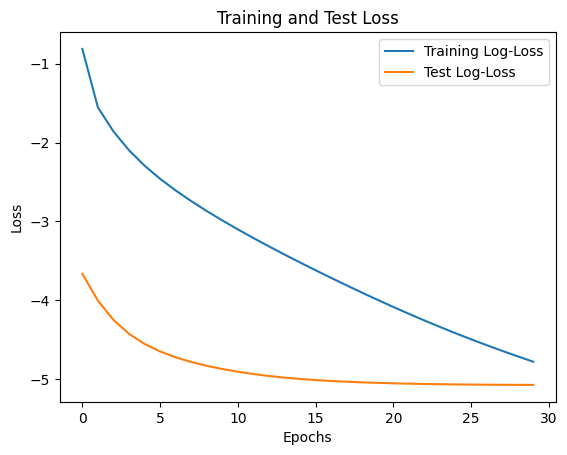

In [5]:
"""
Dataset references:
http://pjreddie.com/media/files/mnist_train.csv
http://pjreddie.com/media/files/mnist_test.csv
"""

from pathlib import Path
from typing import Tuple
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1337)

class MnistMlp(torch.nn.Module):
    
    def __init__(self, inputnodes: int, hiddennodes: int, outputnodes: int) -> None:
        super().__init__()

         # number of nodes (neurons) in input, hidden, and output layers
        self.wih = torch.nn.Linear(in_features=inputnodes, out_features=hiddennodes)
        self.dropout = torch.nn.Dropout(0.2)  # Dropout for the first hidden layer
        self.who = torch.nn.Linear(in_features=hiddennodes, out_features=outputnodes)
        self.activation = torch.nn.Sigmoid()

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.wih(x)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.who(out)
        return out


class MnistDataset(Dataset):
    
    def __init__(self, filepath: Path) -> None:
        super().__init__()

        self.data_list = None
        with open(filepath, "r") as f:
            self.data_list = f.readlines()

        # conver string data to torch Tensor data type
        self.features = []
        self.targets = []
        for record in self.data_list:
            all_values = record.split(",")
            features = np.asfarray(all_values[1:])
            target = int(all_values[0])
            self.features.append(features)
            self.targets.append(target)

        self.features = torch.tensor(np.array(self.features), dtype=torch.float) / 255.0
        self.targets = torch.tensor(np.array(self.targets), dtype=torch.long)
        # print(self.features.shape)
        # print(self.targets.shape)
        # print(self.features.max(), self.features.min())

    
    def __len__(self) -> int:
        return len(self.features)
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.features[index], self.targets[index]


if __name__ == "__main__":
    # Device for training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize empty lists to store training and test losses during training
    training_losses = []
    test_losses = []

    # NN architecture:
    # number of input, hidden and output nodes
    input_nodes = 784
    hidden_nodes = 200
    output_nodes = 10

    # learning rate is 0.1
    learning_rate = 0.1
    # batch size
    batch_size = 10
    # number of epochs
    epochs = 30

    # Load mnist training and testing data CSV file into a datasets
    train_dataset = MnistDataset(filepath="./mnist_train.csv")
    test_dataset = MnistDataset(filepath="./mnist_test.csv")

    # Make data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    # Define NN
    model = MnistMlp(inputnodes=input_nodes, 
                     hiddennodes=hidden_nodes, 
                     outputnodes=output_nodes)
    # Number of parameters in the model
    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    model = model.to(device=device)
    
    # Define Loss
    criterion = torch.nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    ##### Training! #####
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        test_loss = 0.0
        correct = 0

        for batch_idx, (features, target) in enumerate(train_loader):
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(features), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            
            # Accumulate the running loss
            running_loss += loss.item()
    
        # Calculate the average training loss for the epoch
        average_train_loss = running_loss / len(train_loader)
        training_losses.append(average_train_loss)
        ##### Testing! #####
        model.eval()
        with torch.inference_mode():
            for features, target in test_loader:
                features, target = features.to(device), target.to(device)
                output = model(features)
                test_loss += criterion(output, target).item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    ##### Plotting Loss! #####
    plt.plot(range(len(training_losses)), np.log(training_losses), label='Training Log-Loss')
    plt.plot(range(len(test_losses)), np.log(test_losses), label='Test Log-Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

    ##### Save Model! #####
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    torch.save(model.state_dict(), "mnist_02.pth")



The "dropout" model is a little bit bettter: Average testing loss: 0.0062, Accuracy: 0.9803. The testing log-loss seems to be minimum after 15 epochs. Let's add batch normalization layer.

Using device: cpu
# Params: 159410
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.329092
Train Epoch: 0 [1000/60000 (2%)]	Loss: 1.064087
Train Epoch: 0 [2000/60000 (3%)]	Loss: 0.505170
Train Epoch: 0 [3000/60000 (5%)]	Loss: 0.249548
Train Epoch: 0 [4000/60000 (7%)]	Loss: 0.623156
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.182841
Train Epoch: 0 [6000/60000 (10%)]	Loss: 0.189340
Train Epoch: 0 [7000/60000 (12%)]	Loss: 0.524354
Train Epoch: 0 [8000/60000 (13%)]	Loss: 0.420649
Train Epoch: 0 [9000/60000 (15%)]	Loss: 0.657255
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.197456
Train Epoch: 0 [11000/60000 (18%)]	Loss: 0.050346
Train Epoch: 0 [12000/60000 (20%)]	Loss: 0.083812
Train Epoch: 0 [13000/60000 (22%)]	Loss: 0.585882
Train Epoch: 0 [14000/60000 (23%)]	Loss: 1.310241
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.474702
Train Epoch: 0 [16000/60000 (27%)]	Loss: 0.317341
Train Epoch: 0 [17000/60000 (28%)]	Loss: 0.437373
Train Epoch: 0 [18000/60000 (30%)]	Loss: 0.769734
Train Epoch: 0 [19000/60000 (32%)]

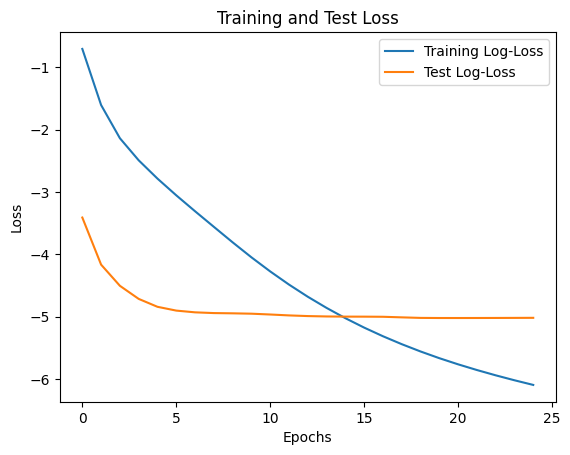

In [6]:
"""
Dataset references:
http://pjreddie.com/media/files/mnist_train.csv
http://pjreddie.com/media/files/mnist_test.csv
"""

from pathlib import Path
from typing import Tuple
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1337)

class MnistMlp(torch.nn.Module):
    
    def __init__(self, inputnodes: int, hiddennodes: int, outputnodes: int) -> None:
        super().__init__()

         # number of nodes (neurons) in input, hidden, and output layers
        self.wih = torch.nn.Linear(in_features=inputnodes, out_features=hiddennodes)
        self.bn1 = torch.nn.BatchNorm1d(hiddennodes)  # Batch Normalization for first hidden layer
        self.dropout = torch.nn.Dropout(0.2)  # Dropout for the first hidden layer
        self.who = torch.nn.Linear(in_features=hiddennodes, out_features=outputnodes)
        self.activation = torch.nn.Sigmoid()

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.wih(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.who(out)
        return out


class MnistDataset(Dataset):
    
    def __init__(self, filepath: Path) -> None:
        super().__init__()

        self.data_list = None
        with open(filepath, "r") as f:
            self.data_list = f.readlines()

        # conver string data to torch Tensor data type
        self.features = []
        self.targets = []
        for record in self.data_list:
            all_values = record.split(",")
            features = np.asfarray(all_values[1:])
            target = int(all_values[0])
            self.features.append(features)
            self.targets.append(target)

        self.features = torch.tensor(np.array(self.features), dtype=torch.float) / 255.0
        self.targets = torch.tensor(np.array(self.targets), dtype=torch.long)
        # print(self.features.shape)
        # print(self.targets.shape)
        # print(self.features.max(), self.features.min())

    
    def __len__(self) -> int:
        return len(self.features)
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.features[index], self.targets[index]


if __name__ == "__main__":
    # Device for training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize empty lists to store training and test losses during training
    training_losses = []
    test_losses = []

    # NN architecture:
    # number of input, hidden and output nodes
    input_nodes = 784
    hidden_nodes = 200
    output_nodes = 10

    # learning rate is 0.1
    learning_rate = 0.1
    # batch size
    batch_size = 10
    # number of epochs
    epochs = 25

    # Load mnist training and testing data CSV file into a datasets
    train_dataset = MnistDataset(filepath="./mnist_train.csv")
    test_dataset = MnistDataset(filepath="./mnist_test.csv")

    # Make data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    # Define NN
    model = MnistMlp(inputnodes=input_nodes, 
                     hiddennodes=hidden_nodes, 
                     outputnodes=output_nodes)
    # Number of parameters in the model
    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    model = model.to(device=device)
    
    # Define Loss
    criterion = torch.nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    ##### Training! #####
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        test_loss = 0.0
        correct = 0

        for batch_idx, (features, target) in enumerate(train_loader):
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(features), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            
            # Accumulate the running loss
            running_loss += loss.item()
    
        # Calculate the average training loss for the epoch
        average_train_loss = running_loss / len(train_loader)
        training_losses.append(average_train_loss)
        ##### Testing! #####
        model.eval()
        with torch.inference_mode():
            for features, target in test_loader:
                features, target = features.to(device), target.to(device)
                output = model(features)
                test_loss += criterion(output, target).item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    ##### Plotting Loss! #####
    plt.plot(range(len(training_losses)), np.log(training_losses), label='Training Log-Loss')
    plt.plot(range(len(test_losses)), np.log(test_losses), label='Test Log-Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

    ##### Save Model! #####
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    torch.save(model.state_dict(), "mnist_04.pth")



The "dropout-batch-norm" model is somewhat ambivalent: Average testing loss is higher than for a "dropout" model: 0.0066, but accuracy  is higher: 0.9808. So, we can't tell that adding batch normalization improves a performance of the already dropout-regularized model. The testing log-loss seems to be minimum after 5 epochs. Now, let's add the second hidden layer with the batch normalization and dropout layer.

Using device: cpu
# Params: 178710
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.388393
Train Epoch: 0 [1000/60000 (2%)]	Loss: 1.134493
Train Epoch: 0 [2000/60000 (3%)]	Loss: 0.840153
Train Epoch: 0 [3000/60000 (5%)]	Loss: 0.600026
Train Epoch: 0 [4000/60000 (7%)]	Loss: 0.841522
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.385994
Train Epoch: 0 [6000/60000 (10%)]	Loss: 0.256964
Train Epoch: 0 [7000/60000 (12%)]	Loss: 0.956085
Train Epoch: 0 [8000/60000 (13%)]	Loss: 0.831628
Train Epoch: 0 [9000/60000 (15%)]	Loss: 0.596980
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.376453
Train Epoch: 0 [11000/60000 (18%)]	Loss: 0.176589
Train Epoch: 0 [12000/60000 (20%)]	Loss: 0.282269
Train Epoch: 0 [13000/60000 (22%)]	Loss: 0.875371
Train Epoch: 0 [14000/60000 (23%)]	Loss: 1.034060
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.496245
Train Epoch: 0 [16000/60000 (27%)]	Loss: 0.721591
Train Epoch: 0 [17000/60000 (28%)]	Loss: 0.475114
Train Epoch: 0 [18000/60000 (30%)]	Loss: 1.089767
Train Epoch: 0 [19000/60000 (32%)]

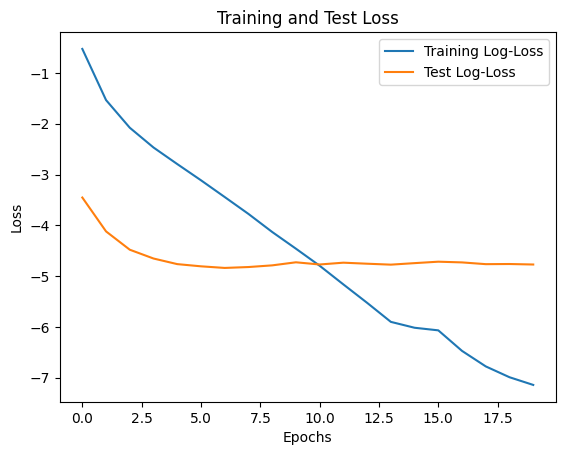

In [7]:
"""
Dataset references:
http://pjreddie.com/media/files/mnist_train.csv
http://pjreddie.com/media/files/mnist_test.csv
"""

from pathlib import Path
from typing import Tuple
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1337)

class MnistMlp(torch.nn.Module):
    
    def __init__(self, inputnodes: int, hiddennodes1: int, hiddennodes2: int, outputnodes: int) -> None:
        super().__init__()

        # Number of nodes (neurons) in input, hidden, and output layers
        self.wih = torch.nn.Linear(in_features=inputnodes, out_features=hiddennodes1)
        self.bn1 = torch.nn.BatchNorm1d(hiddennodes1)  # Batch Normalization for first hidden layer
        self.dropout1 = torch.nn.Dropout(0.2)  # Dropout for the first hidden layer
        self.hidden2 = torch.nn.Linear(in_features=hiddennodes1, out_features=hiddennodes2)
        self.bn2 = torch.nn.BatchNorm1d(hiddennodes2)  # Batch Normalization for the second hidden layer
        self.dropout2 = torch.nn.Dropout(0.2)  # Dropout for the second hidden layer
        self.who = torch.nn.Linear(in_features=hiddennodes2, out_features=outputnodes)
        self.activation = torch.nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.wih(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.dropout1(out)
        out = self.hidden2(out)
        out = self.bn2(out)
        out = self.activation(out)
        out = self.dropout2(out)
        out = self.who(out)
        return out


class MnistDataset(Dataset):
    
    def __init__(self, filepath: Path) -> None:
        super().__init__()

        self.data_list = None
        with open(filepath, "r") as f:
            self.data_list = f.readlines()

        # conver string data to torch Tensor data type
        self.features = []
        self.targets = []
        for record in self.data_list:
            all_values = record.split(",")
            features = np.asfarray(all_values[1:])
            target = int(all_values[0])
            self.features.append(features)
            self.targets.append(target)

        self.features = torch.tensor(np.array(self.features), dtype=torch.float) / 255.0
        self.targets = torch.tensor(np.array(self.targets), dtype=torch.long)
        # print(self.features.shape)
        # print(self.targets.shape)
        # print(self.features.max(), self.features.min())

    
    def __len__(self) -> int:
        return len(self.features)
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.features[index], self.targets[index]


if __name__ == "__main__":
    # Device for training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize empty lists to store training and test losses during training
    training_losses = []
    test_losses = []

    # NN architecture:
    # number of input, hidden and output nodes
    input_nodes = 784
    hidden_nodes1 = 200
    hidden_nodes2 = 100
    output_nodes = 10

    # learning rate is 0.1
    learning_rate = 0.1
    # batch size
    batch_size = 10
    # number of epochs
    epochs = 20

    # Load mnist training and testing data CSV file into a datasets
    train_dataset = MnistDataset(filepath="./mnist_train.csv")
    test_dataset = MnistDataset(filepath="./mnist_test.csv")

    # Make data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    # Define NN
    model = MnistMlp(inputnodes=input_nodes, 
                     hiddennodes1=hidden_nodes1, 
                     hiddennodes2=hidden_nodes2,
                     outputnodes=output_nodes)
    # Number of parameters in the model
    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    model = model.to(device=device)
    
    # Define Loss
    criterion = torch.nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    ##### Training! #####
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        test_loss = 0.0
        correct = 0

        for batch_idx, (features, target) in enumerate(train_loader):
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(features), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            
            # Accumulate the running loss
            running_loss += loss.item()
    
        # Calculate the average training loss for the epoch
        average_train_loss = running_loss / len(train_loader)
        training_losses.append(average_train_loss)
        ##### Testing! #####
        model.eval()
        with torch.inference_mode():
            for features, target in test_loader:
                features, target = features.to(device), target.to(device)
                output = model(features)
                test_loss += criterion(output, target).item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    ##### Plotting Loss! #####
    plt.plot(range(len(training_losses)), np.log(training_losses), label='Training Log-Loss')
    plt.plot(range(len(test_losses)), np.log(test_losses), label='Test Log-Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

    ##### Save Model! #####
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    torch.save(model.state_dict(), "mnist_05.pth")



The "2-hidden-layers" model is a little worse than the previuos models: Average testing loss: 0.0085, Accuracy: 0.9806. That could be due to the already extensive 1-layer model with 159k parameters for 70k of data. Also, it could be due the me using 100 node 2nd hidden layer. The testing log-loss seems to be minimum at 5 epochs. Now, let's experiment with activation functions. I change the activation function to ReLu in the best model, which is 1-hidden layer, batch and dropout model.

Using device: cpu
# Params: 159410
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.457412
Train Epoch: 0 [1000/60000 (2%)]	Loss: 0.903737
Train Epoch: 0 [2000/60000 (3%)]	Loss: 0.164866
Train Epoch: 0 [3000/60000 (5%)]	Loss: 0.150698
Train Epoch: 0 [4000/60000 (7%)]	Loss: 0.513086
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.159936
Train Epoch: 0 [6000/60000 (10%)]	Loss: 0.083161
Train Epoch: 0 [7000/60000 (12%)]	Loss: 0.399071
Train Epoch: 0 [8000/60000 (13%)]	Loss: 0.345077
Train Epoch: 0 [9000/60000 (15%)]	Loss: 0.372959
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.080781
Train Epoch: 0 [11000/60000 (18%)]	Loss: 0.041023
Train Epoch: 0 [12000/60000 (20%)]	Loss: 0.042124
Train Epoch: 0 [13000/60000 (22%)]	Loss: 0.326570
Train Epoch: 0 [14000/60000 (23%)]	Loss: 1.354009
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.395490
Train Epoch: 0 [16000/60000 (27%)]	Loss: 0.229899
Train Epoch: 0 [17000/60000 (28%)]	Loss: 0.223823
Train Epoch: 0 [18000/60000 (30%)]	Loss: 0.638841
Train Epoch: 0 [19000/60000 (32%)]

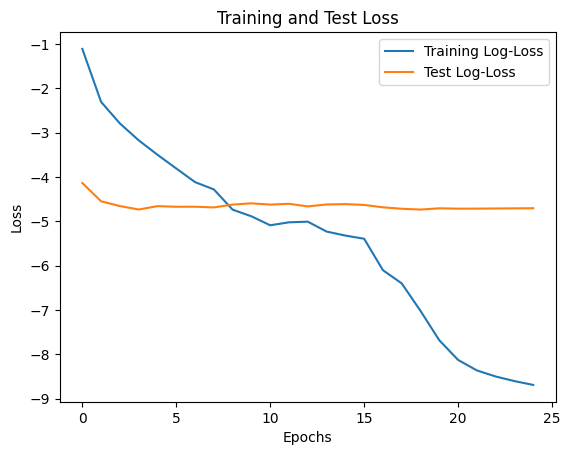

In [8]:
"""
Dataset references:
http://pjreddie.com/media/files/mnist_train.csv
http://pjreddie.com/media/files/mnist_test.csv
"""

from pathlib import Path
from typing import Tuple
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1337)

class MnistMlp(torch.nn.Module):
    
    def __init__(self, inputnodes: int, hiddennodes: int, outputnodes: int) -> None:
        super().__init__()

         # number of nodes (neurons) in input, hidden, and output layers
        self.wih = torch.nn.Linear(in_features=inputnodes, out_features=hiddennodes)
        self.bn1 = torch.nn.BatchNorm1d(hiddennodes)  # Batch Normalization for first hidden layer
        self.dropout = torch.nn.Dropout(0.2)  # Dropout for the first hidden layer
        self.who = torch.nn.Linear(in_features=hiddennodes, out_features=outputnodes)
        self.activation = torch.nn.ReLU()

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.wih(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.who(out)
        return out


class MnistDataset(Dataset):
    
    def __init__(self, filepath: Path) -> None:
        super().__init__()

        self.data_list = None
        with open(filepath, "r") as f:
            self.data_list = f.readlines()

        # conver string data to torch Tensor data type
        self.features = []
        self.targets = []
        for record in self.data_list:
            all_values = record.split(",")
            features = np.asfarray(all_values[1:])
            target = int(all_values[0])
            self.features.append(features)
            self.targets.append(target)

        self.features = torch.tensor(np.array(self.features), dtype=torch.float) / 255.0
        self.targets = torch.tensor(np.array(self.targets), dtype=torch.long)
        # print(self.features.shape)
        # print(self.targets.shape)
        # print(self.features.max(), self.features.min())

    
    def __len__(self) -> int:
        return len(self.features)
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.features[index], self.targets[index]


if __name__ == "__main__":
    # Device for training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize empty lists to store training and test losses during training
    training_losses = []
    test_losses = []

    # NN architecture:
    # number of input, hidden and output nodes
    input_nodes = 784
    hidden_nodes = 200
    output_nodes = 10

    # learning rate is 0.1
    learning_rate = 0.1
    # batch size
    batch_size = 10
    # number of epochs
    epochs = 25

    # Load mnist training and testing data CSV file into a datasets
    train_dataset = MnistDataset(filepath="./mnist_train.csv")
    test_dataset = MnistDataset(filepath="./mnist_test.csv")

    # Make data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    # Define NN
    model = MnistMlp(inputnodes=input_nodes, 
                     hiddennodes=hidden_nodes, 
                     outputnodes=output_nodes)
    # Number of parameters in the model
    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    model = model.to(device=device)
    
    # Define Loss
    criterion = torch.nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    ##### Training! #####
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        test_loss = 0.0
        correct = 0

        for batch_idx, (features, target) in enumerate(train_loader):
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(features), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            
            # Accumulate the running loss
            running_loss += loss.item()
    
        # Calculate the average training loss for the epoch
        average_train_loss = running_loss / len(train_loader)
        training_losses.append(average_train_loss)
        ##### Testing! #####
        model.eval()
        with torch.inference_mode():
            for features, target in test_loader:
                features, target = features.to(device), target.to(device)
                output = model(features)
                test_loss += criterion(output, target).item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    ##### Plotting Loss! #####
    plt.plot(range(len(training_losses)), np.log(training_losses), label='Training Log-Loss')
    plt.plot(range(len(test_losses)), np.log(test_losses), label='Test Log-Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

    ##### Save Model! #####
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    torch.save(model.state_dict(), "mnist_06.pth")



The "ReLU" model is better than "dropout-batch-norm" model in terms of accuracy (0.9825 vs 0.9808), but worse in terms of the average testing loss (0.0090 vs 0.0066). The testing log-loss seems to be minimum even faster: at 3-4 epochs. Now, let's the Tanh activation function for the "dropout-batch-norm" model.

Using device: cpu
# Params: 159410
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.418217
Train Epoch: 0 [1000/60000 (2%)]	Loss: 0.933139
Train Epoch: 0 [2000/60000 (3%)]	Loss: 0.192672
Train Epoch: 0 [3000/60000 (5%)]	Loss: 0.312178
Train Epoch: 0 [4000/60000 (7%)]	Loss: 0.617778
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.071283
Train Epoch: 0 [6000/60000 (10%)]	Loss: 0.089531
Train Epoch: 0 [7000/60000 (12%)]	Loss: 0.483045
Train Epoch: 0 [8000/60000 (13%)]	Loss: 0.211306
Train Epoch: 0 [9000/60000 (15%)]	Loss: 0.313493
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.088401
Train Epoch: 0 [11000/60000 (18%)]	Loss: 0.061890
Train Epoch: 0 [12000/60000 (20%)]	Loss: 0.031823
Train Epoch: 0 [13000/60000 (22%)]	Loss: 0.454853
Train Epoch: 0 [14000/60000 (23%)]	Loss: 0.989567
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.192042
Train Epoch: 0 [16000/60000 (27%)]	Loss: 0.314011
Train Epoch: 0 [17000/60000 (28%)]	Loss: 0.173745
Train Epoch: 0 [18000/60000 (30%)]	Loss: 0.594680
Train Epoch: 0 [19000/60000 (32%)]

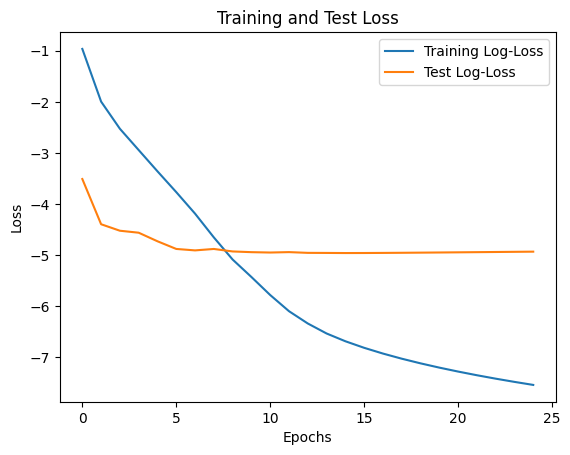

In [9]:
"""
Dataset references:
http://pjreddie.com/media/files/mnist_train.csv
http://pjreddie.com/media/files/mnist_test.csv
"""

from pathlib import Path
from typing import Tuple
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1337)

class MnistMlp(torch.nn.Module):
    
    def __init__(self, inputnodes: int, hiddennodes: int, outputnodes: int) -> None:
        super().__init__()

         # number of nodes (neurons) in input, hidden, and output layers
        self.wih = torch.nn.Linear(in_features=inputnodes, out_features=hiddennodes)
        self.bn1 = torch.nn.BatchNorm1d(hiddennodes)  # Batch Normalization for first hidden layer
        self.dropout = torch.nn.Dropout(0.2)  # Dropout for the first hidden layer
        self.who = torch.nn.Linear(in_features=hiddennodes, out_features=outputnodes)
        self.activation = torch.nn.Tanh()

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.wih(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.who(out)
        return out


class MnistDataset(Dataset):
    
    def __init__(self, filepath: Path) -> None:
        super().__init__()

        self.data_list = None
        with open(filepath, "r") as f:
            self.data_list = f.readlines()

        # conver string data to torch Tensor data type
        self.features = []
        self.targets = []
        for record in self.data_list:
            all_values = record.split(",")
            features = np.asfarray(all_values[1:])
            target = int(all_values[0])
            self.features.append(features)
            self.targets.append(target)

        self.features = torch.tensor(np.array(self.features), dtype=torch.float) / 255.0
        self.targets = torch.tensor(np.array(self.targets), dtype=torch.long)
        # print(self.features.shape)
        # print(self.targets.shape)
        # print(self.features.max(), self.features.min())

    
    def __len__(self) -> int:
        return len(self.features)
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.features[index], self.targets[index]


if __name__ == "__main__":
    # Device for training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize empty lists to store training and test losses during training
    training_losses = []
    test_losses = []

    # NN architecture:
    # number of input, hidden and output nodes
    input_nodes = 784
    hidden_nodes = 200
    output_nodes = 10

    # learning rate is 0.1
    learning_rate = 0.1
    # batch size
    batch_size = 10
    # number of epochs
    epochs = 25

    # Load mnist training and testing data CSV file into a datasets
    train_dataset = MnistDataset(filepath="./mnist_train.csv")
    test_dataset = MnistDataset(filepath="./mnist_test.csv")

    # Make data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    # Define NN
    model = MnistMlp(inputnodes=input_nodes, 
                     hiddennodes=hidden_nodes, 
                     outputnodes=output_nodes)
    # Number of parameters in the model
    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    model = model.to(device=device)
    
    # Define Loss
    criterion = torch.nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    ##### Training! #####
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        test_loss = 0.0
        correct = 0

        for batch_idx, (features, target) in enumerate(train_loader):
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(features), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            
            # Accumulate the running loss
            running_loss += loss.item()
    
        # Calculate the average training loss for the epoch
        average_train_loss = running_loss / len(train_loader)
        training_losses.append(average_train_loss)
        ##### Testing! #####
        model.eval()
        with torch.inference_mode():
            for features, target in test_loader:
                features, target = features.to(device), target.to(device)
                output = model(features)
                test_loss += criterion(output, target).item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    ##### Plotting Loss! #####
    plt.plot(range(len(training_losses)), np.log(training_losses), label='Training Log-Loss')
    plt.plot(range(len(test_losses)), np.log(test_losses), label='Test Log-Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

    ##### Save Model! #####
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    torch.save(model.state_dict(), "mnist_06.pth")



The "Tanh" model is better than "dropout-batch-norm" model in terms of accuracy (0.9819 vs 0.9808), but worse in terms of the average testing loss (0.0072 vs 0.0066). The testing log-loss seems to be minimum at 5 epochs.

Experimenting with the presence / absence of dropout and batch normalization is done in my 1, 2 and 3rd cases. Let's try the model with the batch normalization, but without a dropout.

Using device: cpu
# Params: 159410
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.328853
Train Epoch: 0 [1000/60000 (2%)]	Loss: 0.893140
Train Epoch: 0 [2000/60000 (3%)]	Loss: 0.466722
Train Epoch: 0 [3000/60000 (5%)]	Loss: 0.308050
Train Epoch: 0 [4000/60000 (7%)]	Loss: 0.605626
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.138002
Train Epoch: 0 [6000/60000 (10%)]	Loss: 0.140600
Train Epoch: 0 [7000/60000 (12%)]	Loss: 0.491685
Train Epoch: 0 [8000/60000 (13%)]	Loss: 0.401214
Train Epoch: 0 [9000/60000 (15%)]	Loss: 0.629888
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.159295
Train Epoch: 0 [11000/60000 (18%)]	Loss: 0.068349
Train Epoch: 0 [12000/60000 (20%)]	Loss: 0.055119
Train Epoch: 0 [13000/60000 (22%)]	Loss: 0.560010
Train Epoch: 0 [14000/60000 (23%)]	Loss: 0.938895
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.394394
Train Epoch: 0 [16000/60000 (27%)]	Loss: 0.298061
Train Epoch: 0 [17000/60000 (28%)]	Loss: 0.302371
Train Epoch: 0 [18000/60000 (30%)]	Loss: 0.782673
Train Epoch: 0 [19000/60000 (32%)]

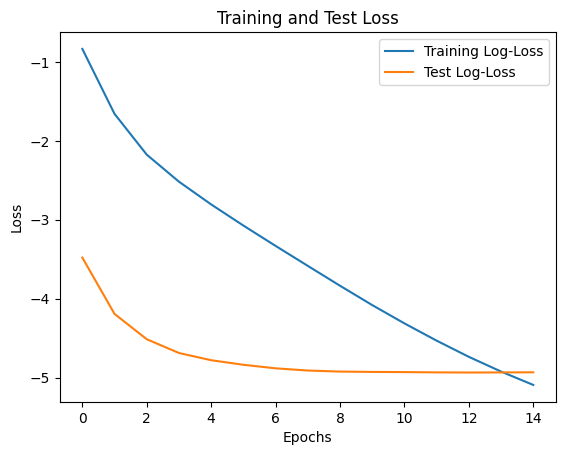

In [10]:
from pathlib import Path
from typing import Tuple
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1337)

class MnistMlp(torch.nn.Module):
    
    def __init__(self, inputnodes: int, hiddennodes: int, outputnodes: int) -> None:
        super().__init__()

         # number of nodes (neurons) in input, hidden, and output layers
        self.wih = torch.nn.Linear(in_features=inputnodes, out_features=hiddennodes)
        self.bn1 = torch.nn.BatchNorm1d(hiddennodes)  # Batch Normalization for first hidden layer
        self.who = torch.nn.Linear(in_features=hiddennodes, out_features=outputnodes)
        self.activation = torch.nn.Sigmoid()

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.wih(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.who(out)
        return out


class MnistDataset(Dataset):
    
    def __init__(self, filepath: Path) -> None:
        super().__init__()

        self.data_list = None
        with open(filepath, "r") as f:
            self.data_list = f.readlines()

        # conver string data to torch Tensor data type
        self.features = []
        self.targets = []
        for record in self.data_list:
            all_values = record.split(",")
            features = np.asfarray(all_values[1:])
            target = int(all_values[0])
            self.features.append(features)
            self.targets.append(target)

        self.features = torch.tensor(np.array(self.features), dtype=torch.float) / 255.0
        self.targets = torch.tensor(np.array(self.targets), dtype=torch.long)
        # print(self.features.shape)
        # print(self.targets.shape)
        # print(self.features.max(), self.features.min())

    
    def __len__(self) -> int:
        return len(self.features)
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.features[index], self.targets[index]


if __name__ == "__main__":
    # Device for training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize empty lists to store training and test losses during training
    training_losses = []
    test_losses = []

    # NN architecture:
    # number of input, hidden and output nodes
    input_nodes = 784
    hidden_nodes = 200
    output_nodes = 10

    # learning rate is 0.1
    learning_rate = 0.1
    # batch size
    batch_size = 10
    # number of epochs
    epochs = 15

    # Load mnist training and testing data CSV file into a datasets
    train_dataset = MnistDataset(filepath="./mnist_train.csv")
    test_dataset = MnistDataset(filepath="./mnist_test.csv")

    # Make data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    # Define NN
    model = MnistMlp(inputnodes=input_nodes, 
                     hiddennodes=hidden_nodes, 
                     outputnodes=output_nodes)
    # Number of parameters in the model
    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    model = model.to(device=device)
    
    # Define Loss
    criterion = torch.nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    ##### Training! #####
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        test_loss = 0.0
        correct = 0

        for batch_idx, (features, target) in enumerate(train_loader):
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(features), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            
            # Accumulate the running loss
            running_loss += loss.item()
    
        # Calculate the average training loss for the epoch
        average_train_loss = running_loss / len(train_loader)
        training_losses.append(average_train_loss)
        ##### Testing! #####
        model.eval()
        with torch.inference_mode():
            for features, target in test_loader:
                features, target = features.to(device), target.to(device)
                output = model(features)
                test_loss += criterion(output, target).item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    ##### Plotting Loss! #####
    plt.plot(range(len(training_losses)), np.log(training_losses), label='Training Log-Loss')
    plt.plot(range(len(test_losses)), np.log(test_losses), label='Test Log-Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

    ##### Save Model! #####
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    torch.save(model.state_dict(), "mnist_07.pth")



The "batch-norm" model is the worst among these 4 cases of "presence / absence of dropout and batch normalization". The testing log-loss seems to be minimum after 5 epochs. So, we can't tell that adding batch normalization itself improves a performance of the already dropout-regularized model.

Now, let's experiment with batch size. I increase the batch size to 100 for the dropout model (model 2).

Using device: cpu
# Params: 159010
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.309719
Train Epoch: 0 [10000/60000 (17%)]	Loss: 1.876813
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.400131
Train Epoch: 0 [30000/60000 (50%)]	Loss: 1.078205
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.708810
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.663425
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.503369
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.477540
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.598952
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.491856
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.372553
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.439964
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.332979
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.375410
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.463554
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.389425
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.312306
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.396409
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.279930
Train Epoch: 3 [10000/60000 (17%)]	

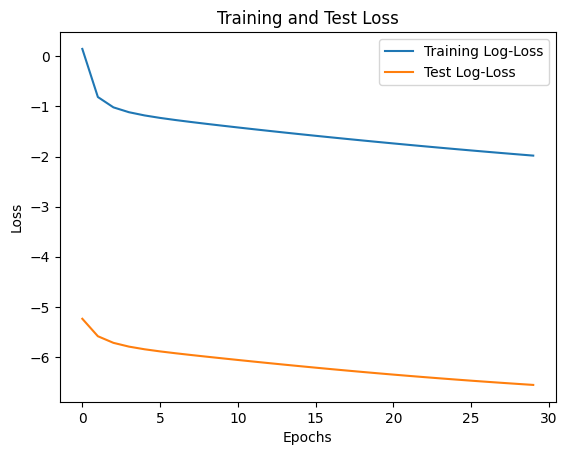

In [12]:
from pathlib import Path
from typing import Tuple
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1337)

class MnistMlp(torch.nn.Module):
    
    def __init__(self, inputnodes: int, hiddennodes: int, outputnodes: int) -> None:
        super().__init__()

         # number of nodes (neurons) in input, hidden, and output layers
        self.wih = torch.nn.Linear(in_features=inputnodes, out_features=hiddennodes)
        self.dropout = torch.nn.Dropout(0.2)  # Dropout for the first hidden layer
        self.who = torch.nn.Linear(in_features=hiddennodes, out_features=outputnodes)
        self.activation = torch.nn.Sigmoid()

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.wih(x)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.who(out)
        return out


class MnistDataset(Dataset):
    
    def __init__(self, filepath: Path) -> None:
        super().__init__()

        self.data_list = None
        with open(filepath, "r") as f:
            self.data_list = f.readlines()

        # conver string data to torch Tensor data type
        self.features = []
        self.targets = []
        for record in self.data_list:
            all_values = record.split(",")
            features = np.asfarray(all_values[1:])
            target = int(all_values[0])
            self.features.append(features)
            self.targets.append(target)

        self.features = torch.tensor(np.array(self.features), dtype=torch.float) / 255.0
        self.targets = torch.tensor(np.array(self.targets), dtype=torch.long)
        # print(self.features.shape)
        # print(self.targets.shape)
        # print(self.features.max(), self.features.min())

    
    def __len__(self) -> int:
        return len(self.features)
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.features[index], self.targets[index]


if __name__ == "__main__":
    # Device for training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize empty lists to store training and test losses during training
    training_losses = []
    test_losses = []

    # NN architecture:
    # number of input, hidden and output nodes
    input_nodes = 784
    hidden_nodes = 200
    output_nodes = 10

    # learning rate is 0.1
    learning_rate = 0.1
    # batch size
    batch_size = 100
    # number of epochs
    epochs = 30

    # Load mnist training and testing data CSV file into a datasets
    train_dataset = MnistDataset(filepath="./mnist_train.csv")
    test_dataset = MnistDataset(filepath="./mnist_test.csv")

    # Make data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    # Define NN
    model = MnistMlp(inputnodes=input_nodes, 
                     hiddennodes=hidden_nodes, 
                     outputnodes=output_nodes)
    # Number of parameters in the model
    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    model = model.to(device=device)
    
    # Define Loss
    criterion = torch.nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    ##### Training! #####
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        test_loss = 0.0
        correct = 0

        for batch_idx, (features, target) in enumerate(train_loader):
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(features), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            
            # Accumulate the running loss
            running_loss += loss.item()
    
        # Calculate the average training loss for the epoch
        average_train_loss = running_loss / len(train_loader)
        training_losses.append(average_train_loss)
        ##### Testing! #####
        model.eval()
        with torch.inference_mode():
            for features, target in test_loader:
                features, target = features.to(device), target.to(device)
                output = model(features)
                test_loss += criterion(output, target).item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    ##### Plotting Loss! #####
    plt.plot(range(len(training_losses)), np.log(training_losses), label='Training Log-Loss')
    plt.plot(range(len(test_losses)), np.log(test_losses), label='Test Log-Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

    ##### Save Model! #####
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    torch.save(model.state_dict(), "mnist_08.pth")

The "100 batches" model is the fastest model to perform and has the smallest average testing loss, but the worst in terms of accuracy. The testing log-loss seems to be be decreasing even after after 30 epochs.